In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal

# Dataset 1

Dataset 1: 2-dimensional data: Linearly separable data set for 3 classes

Classifiers for Dataset 1:
1. K-nearest neighbours classifier, for K=1, K=5 and K=9
2. Bayes classifier with a Gaussian distribution for every class


    * Covariance matrices for all the classes are the same
    * Covariance matrices are different




In [ ]:
train1 = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset1/train.csv")
test1 = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset1/test.csv")
val1 = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset1/val.csv")

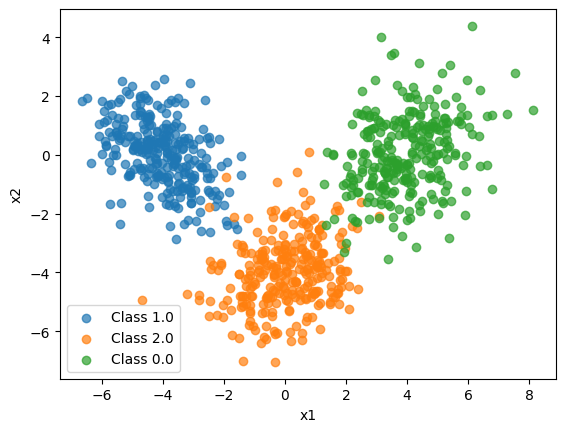

In [ ]:
# Plotting different labels
import matplotlib.pyplot as plt

labels = train1["label"].unique()

for lab in labels:
    subset = train1[train1["label"] == lab]
    plt.scatter(subset["x1"], subset["x2"], label=f"Class {lab}", alpha=0.7)

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In [ ]:
train1.head()

,x1,x2,label
0,-3.888771,1.048737,1.0
1,0.575641,-3.538900,2.0
2,3.363463,-1.671944,0.0
3,4.146677,0.027165,0.0
4,-3.357409,-1.117830,1.0


In [ ]:
train1["label"].unique()

array([1., 2., 0.])

## KNN

In [ ]:
def knn(x1, x2, train, k):
  X = train.iloc[:, :2].values
  y = train.iloc[:, 2].values

  diffs = X - np.array([x1, x2])
  dists = np.linalg.norm(diffs, axis=1)
  distance_arr = np.column_stack((dists, y)).tolist()

  # Sort distance_arr
  distance_arr = sorted(distance_arr)
  knn_arr = distance_arr[:k]

  # Based on freq of class
  class_freq = {0:0, 1:0, 2:0}
  for ele in knn_arr:
    class_freq[ele[1]] += 1

  if class_freq[0] > class_freq[1] and class_freq[0] > class_freq[2]:
    return 0
  elif class_freq[1] > class_freq[0] and class_freq[1] > class_freq[2]:
    return 1
  elif class_freq[2] > class_freq[0] and class_freq[2] > class_freq[1]:
    return 2

  # Sorting ties based on distance
  else:
    max_occ = max(class_freq.values())
    ties = {}
    for i in range(2):
      if class_freq[i] == max_occ: ties[i] = 0

    for i in knn_arr:
      if i[1] in ties.keys(): ties[i[1]] += i[0]

    return min(ties, key=ties.get)

In [ ]:
def knn_acc(df, train, k):
  result = []
  for i in range(len(df)):
    x1, x2 = df.iloc[i, :2]
    true_label = df.iloc[i, 2]
    pred_label = knn(x1, x2, train, k)
    result.append(true_label == pred_label)

  return sum(result)/len(result) * 100

In [ ]:
k_values = [1, 5, 9]

In [ ]:
for k in k_values:
  train_acc = knn_acc(train1, train1, k)
  vall_acc = knn_acc(val1, train1, k)
  test_acc = knn_acc(test1, train1, k)

  print(f"k = {k}")
  print(f"Training accuracy: {train_acc:.3f}")
  print(f"Validation accuracy: {vall_acc:.3f}")
  print(f"Test accuracy: {test_acc:.3f}")
  print()

k = 1
Training accuracy: 100.000
Validation accuracy: 97.917
Test accuracy: 95.833

k = 5
Training accuracy: 98.571
Validation accuracy: 98.333
Test accuracy: 97.500

k = 9
Training accuracy: 97.738
Validation accuracy: 98.333
Test accuracy: 95.833



k = 5 is better

In [ ]:
def plot_knn_decision_region(train, k, h=0.1):
    x_min, x_max = train.iloc[:,0].min() - 1, train.iloc[:,0].max() + 1
    y_min, y_max = train.iloc[:,1].min() - 1, train.iloc[:,1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = np.array([knn(x, y, train, k) for x, y in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")

    plt.scatter(train.iloc[:,0], train.iloc[:,1],
                c=train.iloc[:,2], cmap="tab10", edgecolor="k")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"KNN Decision Regions (k={k})")
    plt.show()

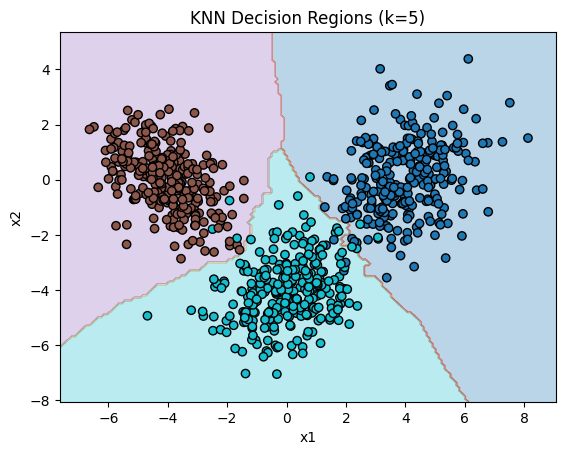

In [ ]:
plot_knn_decision_region(train1, k=5)

In [ ]:
def confusion_matrix_knn(df, train, k):
  result = {"00":0, "01":0, "02":0,
            "10":0, "11":0, "12":0,
            "20":0, "21":0, "22":0}
  for i in range(len(df)):
    x1, x2 = df.iloc[i, :2]
    true_label = df.iloc[i, 2]
    pred_label = knn(x1, x2, train, k)

    tempkey = str(int(true_label)) + str(int(pred_label))
    result[tempkey] += 1

  return result

In [ ]:
k = 5

train_cm = confusion_matrix_knn(train1, train1, k)
vall_cm = confusion_matrix_knn(val1, train1, k)
test_cm = confusion_matrix_knn(test1, train1, k)

In [ ]:
def confusion_matrix(train_cm):
  cm = np.zeros((3, 3), dtype=int)

  for key, val in train_cm.items():
      i, j = int(key[0]), int(key[1])
      cm[i, j] = val

  df_cm = pd.DataFrame(cm,
                      index=[f"True {i}" for i in range(3)],
                      columns=[f"Pred {j}" for j in range(3)])
  plt.figure(figsize=(6,5))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)

  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

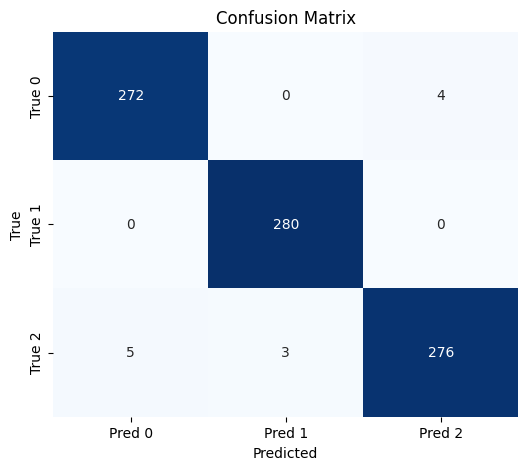

In [ ]:
confusion_matrix(train_cm)

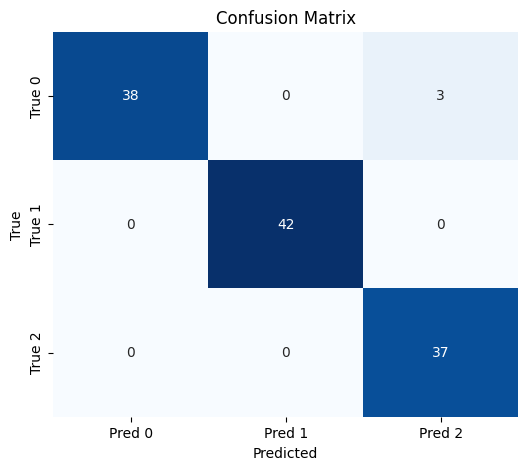

In [ ]:
confusion_matrix(test_cm)

In [ ]:
# Precision, Recall, F1
print("Test Data\n")

p, r, f = [], [], []

for i in range(3):
    tp = test_cm[str(i)+str(i)]
    col_sum = sum(test_cm[str(j)+str(i)] for j in range(3))
    row_sum = sum(test_cm[str(i)+str(j)] for j in range(3))

    precision = tp / col_sum
    recall = tp / row_sum
    f1 = 2 * precision * recall / (precision + recall)

    p.append(precision)
    r.append(recall)
    f.append(f1)

    print(f"Class {i}")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall: {recall:.3f}")
    print(f"\tF1 Score: {f1:.3f}\n")

print(f"Average Precision: {sum(p)/3:.3f}")
print(f"Average Recall: {sum(r)/3:.3f}")
print(f"Average F1 Score: {sum(f)/3:.3f}")

Test Data

Class 0
	Precision: 1.000
	Recall: 0.927
	F1 Score: 0.962

Class 1
	Precision: 1.000
	Recall: 1.000
	F1 Score: 1.000

Class 2
	Precision: 0.925
	Recall: 1.000
	F1 Score: 0.961

Average Precision: 0.975
Average Recall: 0.976
Average F1 Score: 0.974


## Bayes Classifier

In [ ]:
means = [0, 0, 0]
P = [0, 0, 0]
for lab in range(3):
  means[lab] = train1[train1["label"] == lab].iloc[:, :2].mean()
  P[lab] = len(train1[train1["label"] == lab])/len(train1)

### a. Same covariance matrix for all classes

In [ ]:
C = np.zeros((2, 2))
for lab in range(3):
  C += len(train1[train1["label"] == lab]) * np.cov(train1[train1["label"] == lab].iloc[:, :2].T)
C /= len(train1)

In [ ]:
def bayes(x1, x2, means, P, C):
  probs = []
  for lab in range(3):
    diff = np.array([x1, x2]) - means[lab]
    prob = -0.5 * diff.T @ np.linalg.inv(C) @ diff + np.log(P[lab])
    probs.append(prob)

  return np.argmax(probs)

In [ ]:
def bayes_acc(df, means, P, C):
  result = []
  for i in range(len(df)):
    x1, x2 = df.iloc[i, :2]
    true_label = df.iloc[i, 2]
    pred_label = bayes(x1, x2, means, P, C)
    result.append(true_label == pred_label)

  return sum(result)/len(result) * 100

In [ ]:
train_acc = bayes_acc(train1, means, P, C)
val_acc = bayes_acc(val1, means, P, C)
test_acc = bayes_acc(test1, means, P, C)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Training accuracy: 98.095
Validation accuracy: 98.333
Test accuracy: 95.000


In [ ]:
def plot_bayes_decision_region(train, means, P, C, h=0.1):
    x_min, x_max = train.iloc[:,0].min() - 1, train.iloc[:,0].max() + 1
    y_min, y_max = train.iloc[:,1].min() - 1, train.iloc[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = np.array([bayes(x, y, means, P, C) for x, y in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
    plt.scatter(train.iloc[:,0], train.iloc[:,1], c=train.iloc[:,2], cmap="tab10", edgecolor="k")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"Decision Region")
    plt.show()

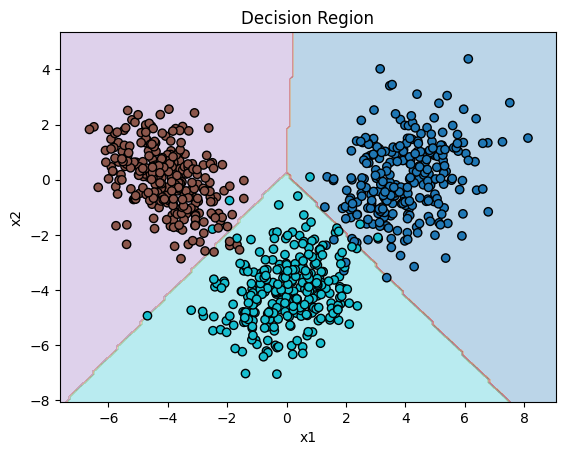

In [ ]:
plot_bayes_decision_region(train1, means, P, C)

In [ ]:
def bayes_cm(df, means, P, C):
    n_classes = len(np.unique(df.iloc[:, 2]))
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i in range(len(df)):
        x = df.iloc[i, :2].values
        true_label = int(df.iloc[i, 2])
        pred_label = bayes(x[0], x[1], means, P, C)
        cm[true_label, pred_label] += 1

    df_cm = pd.DataFrame(cm,
                         index=[f"True {i}" for i in range(n_classes)],
                         columns=[f"Pred {i}" for i in range(n_classes)])
    plt.figure(figsize=(6,5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return cm

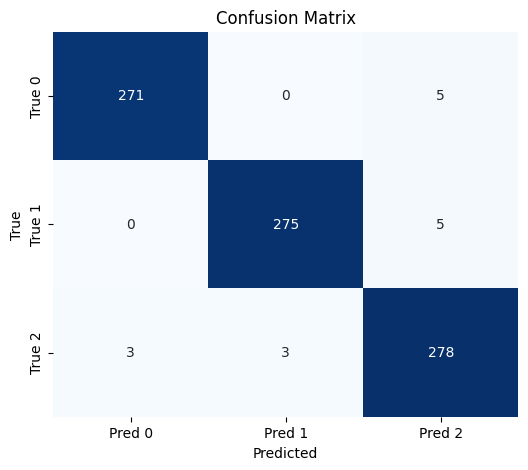

In [ ]:
train_cm = bayes_cm(train1, means, P, C)

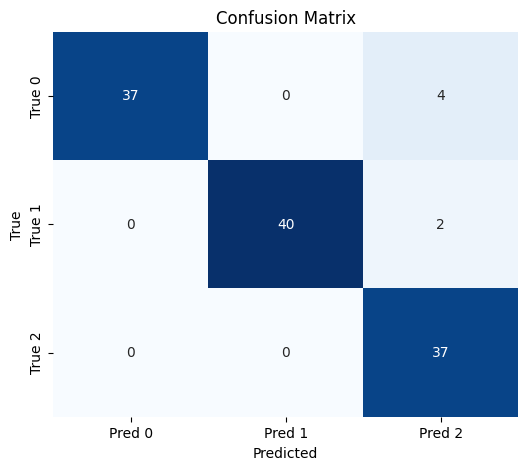

In [ ]:
test_cm = bayes_cm(test1, means, P, C)

In [ ]:
def bayes_metrics(cm):
    n_classes = cm.shape[0]

    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(n_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = 2*precision*recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print("Test Data\n")
    for i in range(n_classes):
        print(f"Class {i}")
        print(f"\tPrecision: {precision_list[i]:.3f}")
        print(f"\tRecall: {recall_list[i]:.3f}")
        print(f"\tF1 Score: {f1_list[i]:.3f}\n")

    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}\n")

In [ ]:
bayes_metrics(test_cm)

Test Data

Class 0
	Precision: 1.000
	Recall: 0.902
	F1 Score: 0.949

Class 1
	Precision: 1.000
	Recall: 0.952
	F1 Score: 0.976

Class 2
	Precision: 0.860
	Recall: 1.000
	F1 Score: 0.925

Average Precision: 0.953
Average Recall: 0.952
Average F1 Score: 0.950



### b. Covariances Matrices are different

In [ ]:
C = np.zeros((2, 2, 3))
for lab in range(3):
  C[:, :, lab] = np.cov(train1[train1["label"] == lab].iloc[:, :2].T)

In [ ]:
def bayes(x1, x2, means, P, C):
  probs = []
  for lab in range(3):
    diff = np.array([x1, x2]) - means[lab]
    prob = -0.5 * diff.T @ np.linalg.inv(C[:, :, lab]) @ diff + np.log(P[lab])
    probs.append(prob)

  return np.argmax(probs)

In [ ]:
train_acc = bayes_acc(train1, means, P, C)
val_acc = bayes_acc(val1, means, P, C)
test_acc = bayes_acc(test1, means, P, C)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Training accuracy: 98.214
Validation accuracy: 98.333
Test accuracy: 95.000


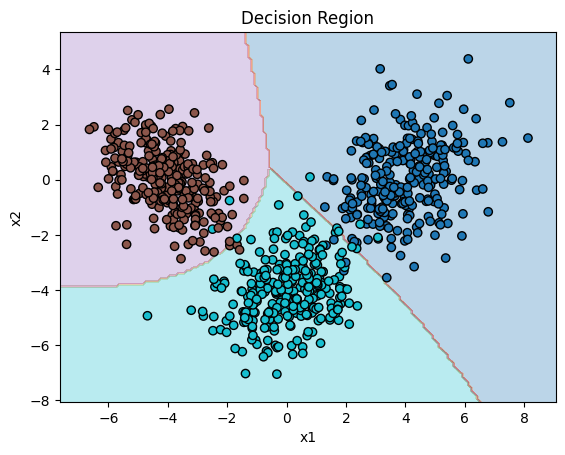

In [ ]:
plot_bayes_decision_region(train1, means, P, C)

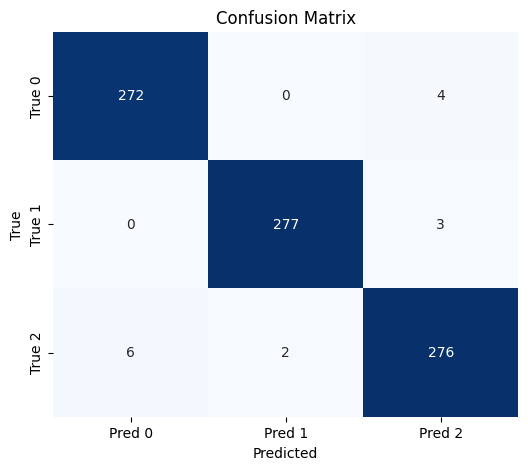

In [ ]:
train_cm = bayes_cm(train1, means, P, C)

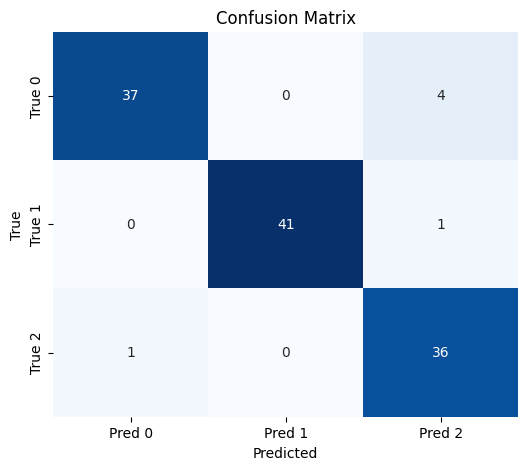

In [ ]:
test_cm = bayes_cm(test1, means, P, C)

In [ ]:
bayes_metrics(test_cm)

Test Data

Class 0
	Precision: 0.974
	Recall: 0.902
	F1 Score: 0.937

Class 1
	Precision: 1.000
	Recall: 0.976
	F1 Score: 0.988

Class 2
	Precision: 0.878
	Recall: 0.973
	F1 Score: 0.923

Average Precision: 0.951
Average Recall: 0.951
Average F1 Score: 0.949



# Dataset 2

Dataset 2: 2-dimensional data: Nonlinearly separable data set for 2 classes

Classifiers for Dataset 2:
1. K-nearest neighbours classifier, for K=1, K=5 and K=9
2. Bayes classifier with a Gaussian distribution for every class
    * Covariance matrices for all the classes are the same
    * Covariance matrices are different
3. Naive-Bayes classifier with a Gaussian distribution for every class
    * Covariance matrices for all the classes are the same
    * Covariance matrices are different
4. GMM based classifier (Q = 4, 6, 8, 10) using
    * Full covariance matrices
    * Diagonal covariance matrices

In [ ]:
train2 = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset2/train.csv")
test2 = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset2/test.csv")
val2 = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset2/val.csv")

In [ ]:
train2.head()

,x1,x2,label
0,1.550241,0.023147,1
1,0.650304,0.385759,0
2,1.727335,-0.033070,1
3,0.377667,0.428559,1
4,0.037575,0.342438,1


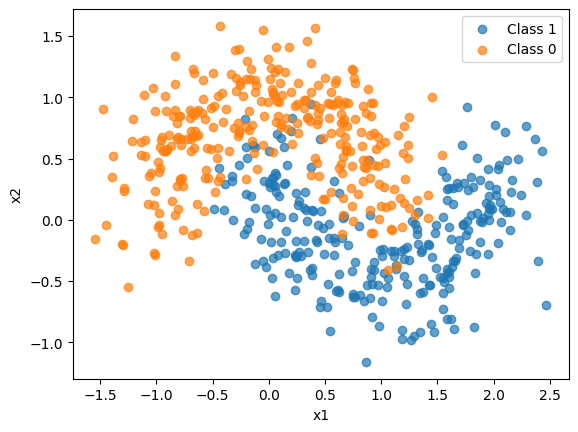

In [ ]:
import matplotlib.pyplot as plt

labels = train2["label"].unique()

for lab in labels:
    subset = train2[train2["label"] == lab]
    plt.scatter(subset["x1"], subset["x2"], label=f"Class {lab}", alpha=0.7)

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## KNN

In [ ]:
def knn(x1, x2, train, k):
  X = train.iloc[:, :2].values
  y = train.iloc[:, 2].values

  diffs = X - np.array([x1, x2])
  dists = np.linalg.norm(diffs, axis=1)
  distance_arr = np.column_stack((dists, y)).tolist()

  # Sort distance_arr
  distance_arr = sorted(distance_arr)
  knn_arr = distance_arr[:k]

  # Based on freq of class
  class_freq = {0:0, 1:0}
  for ele in knn_arr:
    class_freq[ele[1]] += 1

  if class_freq[0] > class_freq[1]:
    return 0
  elif class_freq[1] > class_freq[0]:
    return 1

  # Sorting ties based on distance
  else:
    max_occ = max(class_freq.values())
    ties = {1:0, 2:0}

    for i in knn_arr:
      ties[i[1]] += i[0]

    return min(ties, key=ties.get)

In [ ]:
def knn_acc(df, train, k):
  result = []
  for i in range(len(df)):
    x1, x2 = df.iloc[i, :2]
    true_label = df.iloc[i, 2]
    pred_label = knn(x1, x2, train, k)
    result.append(true_label == pred_label)

  return sum(result)/len(result) * 100

In [ ]:
k_values = [1, 5, 9]

In [ ]:
for k in k_values:
  train_acc = knn_acc(train2, train2, k)
  vall_acc = knn_acc(val2, train2, k)
  test_acc = knn_acc(test2, train2, k)

  print(f"k = {k}")
  print(f"Training accuracy: {train_acc:.3f}")
  print(f"Validation accuracy: {vall_acc:.3f}")
  print(f"Test accuracy: {test_acc:.3f}")
  print()

k = 1
Training accuracy: 100.000
Validation accuracy: 94.340
Test accuracy: 93.750

k = 5
Training accuracy: 94.118
Validation accuracy: 95.597
Test accuracy: 100.000

k = 9
Training accuracy: 94.296
Validation accuracy: 96.226
Test accuracy: 97.500



In [ ]:
def plot_knn_decision_region(train, k, h=0.1):
    x_min, x_max = train.iloc[:,0].min() - 1, train.iloc[:,0].max() + 1
    y_min, y_max = train.iloc[:,1].min() - 1, train.iloc[:,1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = np.array([knn(x, y, train, k) for x, y in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    plt.scatter(train.iloc[:,0], train.iloc[:,1],
                c=train.iloc[:,2], edgecolor="k")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"KNN Decision Regions (k={k})")
    plt.show()

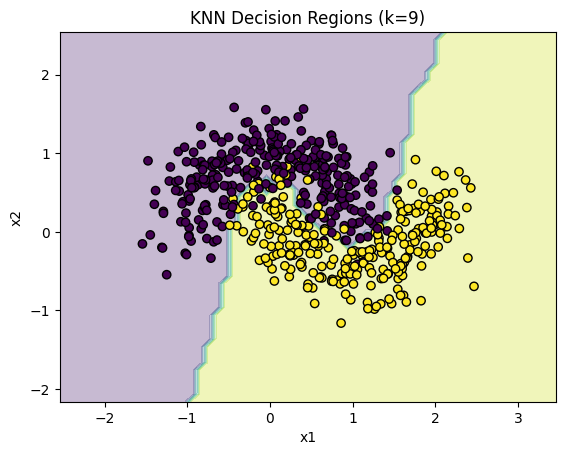

In [ ]:
plot_knn_decision_region(train2, k=9, h=0.1)

In [ ]:
def confusion_matrix_knn(df, train, k):
  result = {"00":0, "01":0,
            "10":0, "11":0,}
  for i in range(len(df)):
    x1, x2 = df.iloc[i, :2]
    true_label = df.iloc[i, 2]
    pred_label = knn(x1, x2, train, k)

    tempkey = str(int(true_label)) + str(int(pred_label))
    result[tempkey] += 1

  return result

In [ ]:
k = 9

train_cm = confusion_matrix_knn(train2, train2, k)
vall_cm = confusion_matrix_knn(val2, train2, k)
test_cm = confusion_matrix_knn(test2, train2, k)

In [ ]:
def confusion_matrix(train_cm):
  cm = np.zeros((2, 2), dtype=int)

  for key, val in train_cm.items():
      i, j = int(key[0]), int(key[1])
      cm[i, j] = val

  df_cm = pd.DataFrame(cm,
                      index=[f"True {i}" for i in range(2)],
                      columns=[f"Pred {j}" for j in range(2)])
  plt.figure(figsize=(6,5))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)

  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

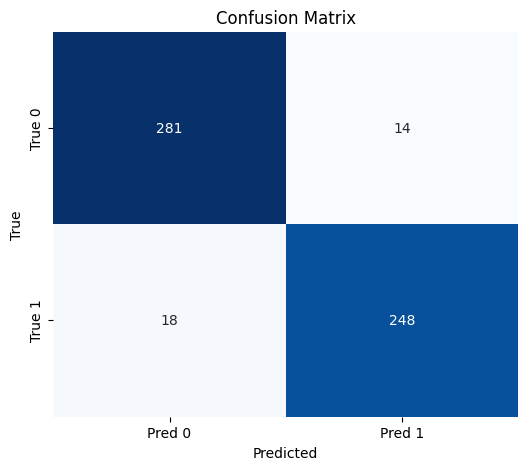

In [ ]:
confusion_matrix(train_cm)

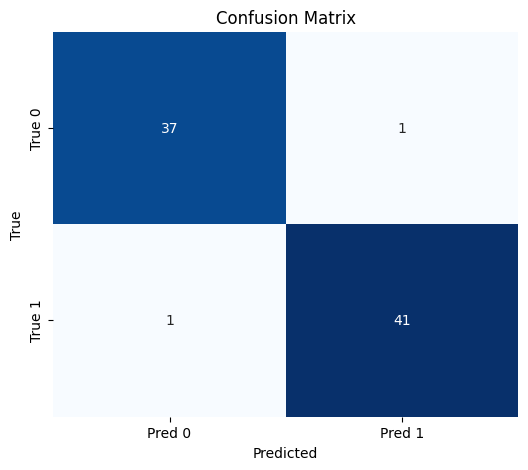

In [ ]:
confusion_matrix(test_cm)

In [ ]:
# Precision, Recall, F1
print("Test Data\n")

p, r, f = [], [], []

for i in range(2):
    tp = test_cm[str(i)+str(i)]
    col_sum = sum(test_cm[str(j)+str(i)] for j in range(2))
    row_sum = sum(test_cm[str(i)+str(j)] for j in range(2))

    precision = tp / col_sum
    recall = tp / row_sum
    f1 = 2 * precision * recall / (precision + recall)

    p.append(precision)
    r.append(recall)
    f.append(f1)

    print(f"Class {i}")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall: {recall:.3f}")
    print(f"\tF1 Score: {f1:.3f}\n")

print(f"Average Precision: {sum(p)/2:.3f}")
print(f"Average Recall: {sum(r)/2:.3f}")
print(f"Average F1 Score: {sum(f)/2:.3f}")

Test Data

Class 0
	Precision: 0.974
	Recall: 0.974
	F1 Score: 0.974

Class 1
	Precision: 0.976
	Recall: 0.976
	F1 Score: 0.976

Average Precision: 0.975
Average Recall: 0.975
Average F1 Score: 0.975


## Bayes Classifier

In [ ]:
means = [0, 0]
P = [0, 0]
for lab in range(2):
  means[lab] = train2[train2["label"] == lab].iloc[:, :2].mean()
  P[lab] = len(train2[train2["label"] == lab])/len(train2)

### a. Same covariance matrix for all classes

In [ ]:
C = np.zeros((2, 2))
for lab in range(2):
  C += len(train2[train2["label"] == lab]) * np.cov(train2[train2["label"] == lab].iloc[:, :2].T)
C /= len(train2)

In [ ]:
def bayes(x1, x2, means, P, C):
  probs = []
  for lab in range(2):
    diff = np.array([x1, x2]) - means[lab]
    prob = -0.5 * diff.T @ np.linalg.inv(C) @ diff + np.log(P[lab])
    probs.append(prob)

  return np.argmax(probs)

In [ ]:
def bayes_acc(df, means, P, C):
  result = []
  for i in range(len(df)):
    x1, x2 = df.iloc[i, :2]
    true_label = df.iloc[i, 2]
    pred_label = bayes(x1, x2, means, P, C)
    result.append(true_label == pred_label)

  return sum(result)/len(result) * 100

In [ ]:
train_acc = bayes_acc(train2, means, P, C)
val_acc = bayes_acc(val2, means, P, C)
test_acc = bayes_acc(test2, means, P, C)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Training accuracy: 85.027
Validation accuracy: 85.535
Test accuracy: 86.250


In [ ]:
def plot_bayes_decision_region(train, means, P, C, h=0.1):
    x_min, x_max = train.iloc[:,0].min() - 1, train.iloc[:,0].max() + 1
    y_min, y_max = train.iloc[:,1].min() - 1, train.iloc[:,1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = np.array([bayes(x, y, means, P, C) for x, y in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")

    plt.scatter(train.iloc[:,0], train.iloc[:,1],
                c=train.iloc[:,2], cmap="tab10", edgecolor="k")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"Decision Region")
    plt.show()

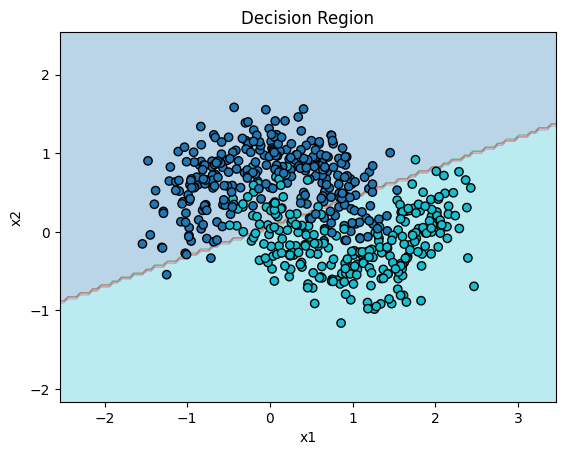

In [ ]:
plot_bayes_decision_region(train2, means, P, C, 0.05)

In [ ]:
def bayes_cm(df, means, P, C):
    n_classes = len(np.unique(df.iloc[:, 2]))
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i in range(len(df)):
        x = df.iloc[i, :2].values
        true_label = int(df.iloc[i, 2])
        pred_label = bayes(x[0], x[1], means, P, C)
        cm[true_label, pred_label] += 1

    df_cm = pd.DataFrame(cm,
                         index=[f"True {i}" for i in range(n_classes)],
                         columns=[f"Pred {i}" for i in range(n_classes)])
    plt.figure(figsize=(6,5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return cm

In [ ]:
def bayes_metrics(cm):
    n_classes = cm.shape[0]

    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(n_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = 2*precision*recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print("Test Data\n")
    for i in range(n_classes):
        print(f"Class {i}")
        print(f"\tPrecision: {precision_list[i]:.3f}")
        print(f"\tRecall: {recall_list[i]:.3f}")
        print(f"\tF1 Score: {f1_list[i]:.3f}\n")

    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}\n")


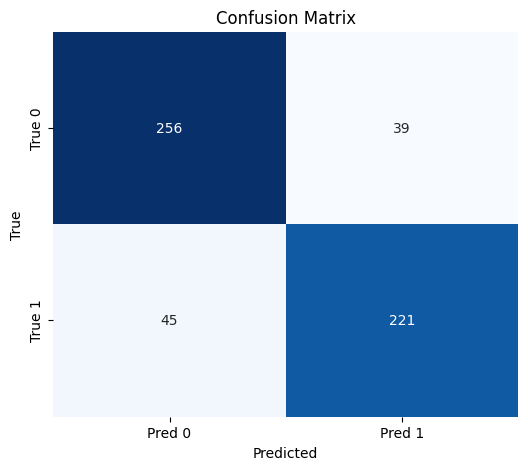

In [ ]:
train_cm = bayes_cm(train2, means, P, C)

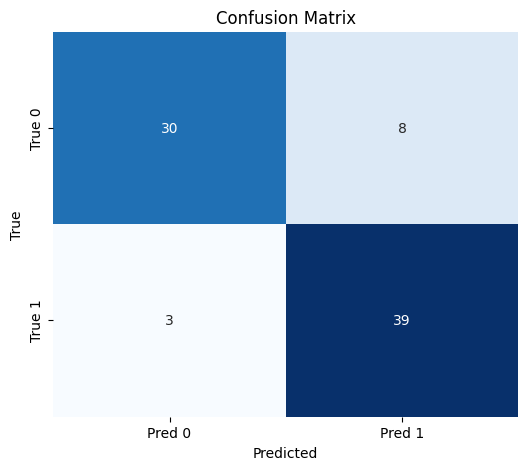

In [ ]:
test_cm = bayes_cm(test2, means, P, C)

In [ ]:
bayes_metrics(test_cm)

Test Data

Class 0
	Precision: 0.909
	Recall: 0.789
	F1 Score: 0.845

Class 1
	Precision: 0.830
	Recall: 0.929
	F1 Score: 0.876

Average Precision: 0.869
Average Recall: 0.859
Average F1 Score: 0.861



### b. Covariances Matrices are different

In [ ]:
C = np.zeros((2, 2, 2))
for lab in range(2):
  C[:, :, lab] = np.cov(train2[train2["label"] == lab].iloc[:, :2].T)

In [ ]:
def bayes(x1, x2, means, P, C):
  probs = []
  for lab in range(2):
    diff = np.array([x1, x2]) - means[lab]
    prob = -0.5 * diff.T @ np.linalg.inv(C[:, :, lab]) @ diff + np.log(P[lab])
    probs.append(prob)

  return np.argmax(probs)

In [ ]:
train_acc = bayes_acc(train2, means, P, C)
val_acc = bayes_acc(val2, means, P, C)
test_acc = bayes_acc(test2, means, P, C)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Training accuracy: 84.848
Validation accuracy: 84.906
Test accuracy: 86.250


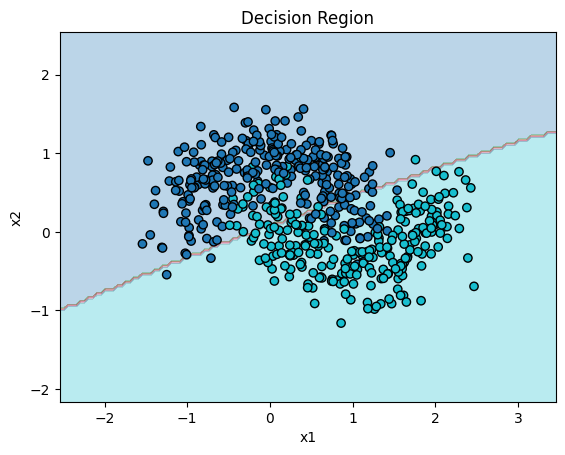

In [ ]:
plot_bayes_decision_region(train2, means, P, C, 0.05)

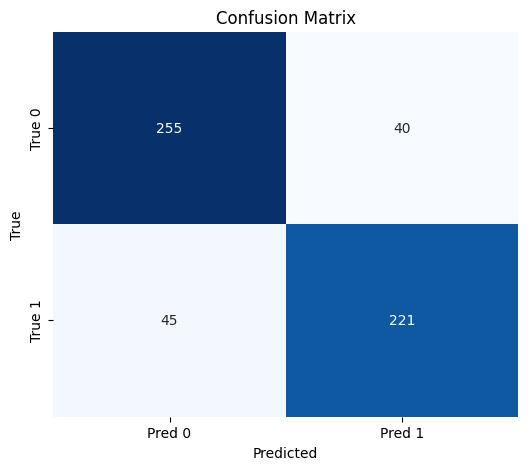

In [ ]:
train_cm = bayes_cm(train2, means, P, C)

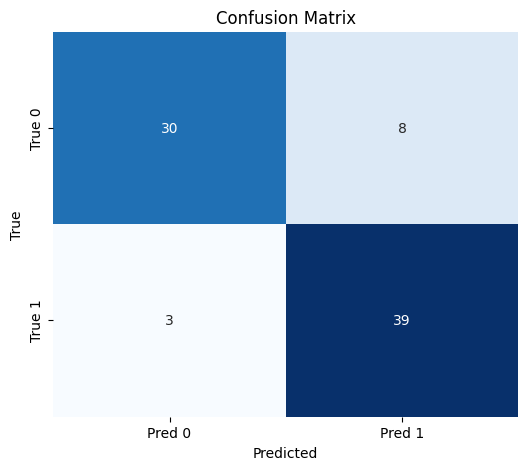

In [ ]:
test_cm = bayes_cm(test2, means, P, C)

In [ ]:
bayes_metrics(test_cm)

Test Data

Class 0
	Precision: 0.909
	Recall: 0.789
	F1 Score: 0.845

Class 1
	Precision: 0.830
	Recall: 0.929
	F1 Score: 0.876

Average Precision: 0.869
Average Recall: 0.859
Average F1 Score: 0.861



# Dataset 3

Dataset 3: Image data set (Dimension of feature vector: 36) for 5 classes

Classifiers for Dataset 3:
1. K-nearest neighbours classifier, for K=1, K=9 and K=15
2. Bayes classifier with a Gaussian distribution for every class
3. Naive-Bayes classifier with a Gaussian distribution for every class
4. GMM based classifier (Q = 2, 3, 4, 5) using
    * Full covariance matrices
    * Diagonal covariance matrices

In [ ]:
train3_data = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset3/train_data.csv", header=None)
test3_data = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset3/test_data.csv", header=None)
val3_data = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset3/val_data.csv", header=None)

In [ ]:
train3_data.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.234667,0.067002,0.234667,0.234667,0.234667,0.052782,0.126665,0.234667,0.193619,0.201921,...,0.139963,0.146104,0.038461,0.219555,0.073700,0.234667,0.203861,0.122210,0.145820,0.092846
1,0.232526,0.232526,0.232526,0.158067,0.232526,0.043733,0.127873,0.093283,0.232526,0.218587,...,0.185950,0.232526,0.068798,0.090132,0.070781,0.086830,0.144792,0.099514,0.087593,0.219279
2,0.244535,0.114003,0.080552,0.116492,0.143606,0.089520,0.018102,0.080340,0.151313,0.118813,...,0.244535,0.244535,0.244535,0.244535,0.150239,0.244535,0.202609,0.133530,0.132476,0.191413
3,0.268649,0.101484,0.111542,0.187980,0.186632,0.066074,0.057798,0.065813,0.128342,0.268649,...,0.222081,0.268649,0.090754,0.092206,0.109357,0.268649,0.267764,0.230715,0.096315,0.226850
4,0.161802,0.240126,0.240126,0.240126,0.240126,0.124308,0.107134,0.079594,0.128025,0.179312,...,0.146343,0.190926,0.145834,0.107340,0.090701,0.132925,0.080151,0.148467,0.076519,0.240126


In [ ]:
train3_label = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset3/train_label.csv", header=None, names=["label"])
test3_label = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset3/test_label.csv", header=None, names=["label"])
val3_label = pd.read_csv(r"/content/drive/MyDrive/PRML/Assignment-2/Dataset3/val_label.csv", header=None, names=["label"])

In [ ]:
train3 = pd.concat([train3_data, train3_label], axis=1)
test3 = pd.concat([test3_data, test3_label], axis=1)
val3 = pd.concat([val3_data, val3_label], axis=1)

In [ ]:
train3.tail()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,label
1995,0.146348,0.225558,0.192072,0.177327,0.206885,0.079473,0.050043,0.066048,0.073445,0.132474,...,0.170629,0.131789,0.170845,0.213691,0.225558,0.187914,0.171199,0.225558,0.188063,4.0
1996,0.097761,0.158431,0.241758,0.119671,0.277213,0.155901,0.052383,0.164944,0.085223,0.125102,...,0.085720,0.097014,0.103236,0.228661,0.277213,0.277213,0.264033,0.277213,0.142929,4.0
1997,0.141483,0.045598,0.145041,0.245009,0.193037,0.054401,0.048155,0.188030,0.245009,0.214529,...,0.119388,0.172139,0.245009,0.140198,0.093972,0.107060,0.245009,0.245009,0.157326,4.0
1998,0.252452,0.046537,0.032263,0.060851,0.073090,0.088801,0.252452,0.222632,0.252452,0.153868,...,0.149613,0.198096,0.252452,0.229926,0.102519,0.111572,0.173869,0.143799,0.158069,4.0
1999,0.033357,0.158278,0.245831,0.239183,0.131851,0.039685,0.007138,0.012440,0.016863,0.134497,...,0.198229,0.121018,0.069716,0.111853,0.230860,0.245831,0.245831,0.245831,0.234696,4.0


## KNN

In [ ]:
def knn(x, train, k):
  X = train.iloc[:, :-1].values
  y = train.iloc[:, -1].values

  diffs = X - np.array(x)
  dists = np.linalg.norm(diffs, axis=1)
  distance_arr = np.column_stack((dists, y)).tolist()

  # Sort distance_arr
  distance_arr = sorted(distance_arr)
  knn_arr = distance_arr[:k]

  # Based on freq of class
  class_freq = {c: 0 for c in range(5)}
  for dist, label in knn_arr:
      class_freq[label] += 1

  max_occ = max(class_freq.values())
  candidates = [c for c, freq in class_freq.items() if freq == max_occ]

  if len(candidates) == 1:
      return candidates[0]
  else:
      class_dist_sum = {c: 0 for c in candidates}
      for dist, label in knn_arr:
          if label in class_dist_sum:
              class_dist_sum[label] += dist

      return min(class_dist_sum, key=class_dist_sum.get)

In [ ]:
def knn_acc(df, train, k):
  result = []
  for i in range(len(df)):
    X = df.iloc[i, :-1]
    true_label = df.iloc[i, -1]
    pred_label = knn(X, train, k)
    result.append(true_label == pred_label)

  return sum(result)/len(result) * 100

In [ ]:
k_values = [1, 9, 15]

In [ ]:
for k in k_values:
  train_acc = knn_acc(train3, train3, k)
  vall_acc = knn_acc(val3, train3, k)
  test_acc = knn_acc(test3, train3, k)

  print(f"k = {k}")
  print(f"Training accuracy: {train_acc:.3f}")
  print(f"Validation accuracy: {vall_acc:.3f}")
  print(f"Test accuracy: {test_acc:.3f}")
  print()

k = 1
Training accuracy: 100.000
Validation accuracy: 41.400
Test accuracy: 44.400

k = 9
Training accuracy: 66.950
Validation accuracy: 45.000
Test accuracy: 49.800

k = 15
Training accuracy: 61.500
Validation accuracy: 48.600
Test accuracy: 49.400



We choose k=15

In [ ]:
def confusion_matrix_knn(df, train, k):
  result = {}
  for i in range(5):
    for j in range(5): result[str(i)+str(j)] = 0

  for i in range(len(df)):
    X = df.iloc[i, :-1]
    true_label = df.iloc[i, -1]
    pred_label = knn(X, train, k)

    tempkey = str(int(true_label)) + str(int(pred_label))
    result[tempkey] += 1

  return result

In [ ]:
k = 15

train_cm = confusion_matrix_knn(train3, train3, k)
vall_cm = confusion_matrix_knn(val3, train3, k)
test_cm = confusion_matrix_knn(test3, train3, k)

In [ ]:
def confusion_matrix(train_cm):
  cm = np.zeros((5, 5), dtype=int)

  for key, val in train_cm.items():
      i, j = int(key[0]), int(key[1])
      cm[i, j] = val

  df_cm = pd.DataFrame(cm,
                      index=[f"True {i}" for i in range(5)],
                      columns=[f"Pred {j}" for j in range(5)])
  plt.figure(figsize=(6,5))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)

  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

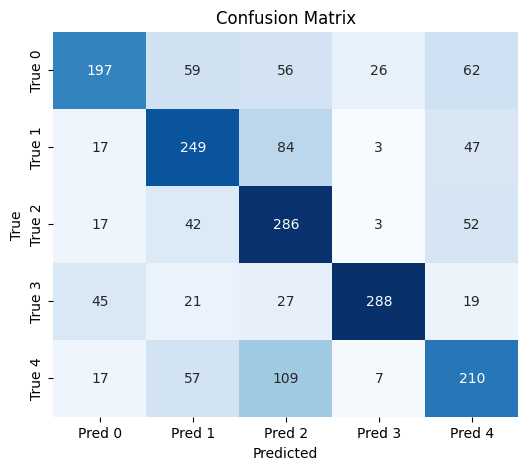

In [ ]:
confusion_matrix(train_cm)

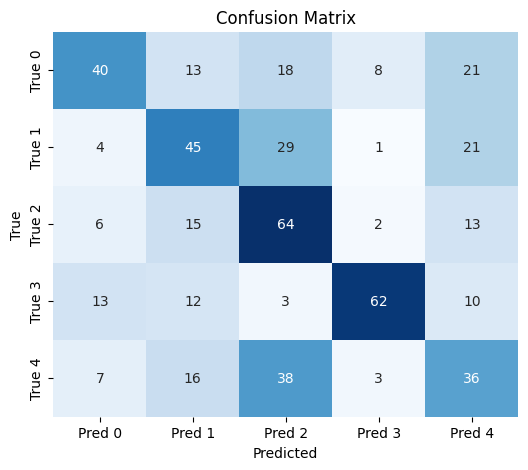

In [ ]:
confusion_matrix(test_cm)

In [ ]:
# Precision, Recall, F1
print("Test Data\n")

p, r, f = [], [], []

for i in range(5):
    tp = test_cm[str(i)+str(i)]
    col_sum = sum(test_cm[str(j)+str(i)] for j in range(5))
    row_sum = sum(test_cm[str(i)+str(j)] for j in range(5))

    precision = tp / col_sum
    recall = tp / row_sum
    f1 = 2 * precision * recall / (precision + recall)

    p.append(precision)
    r.append(recall)
    f.append(f1)

    print(f"Class {i}")
    print(f"\tPrecision: {precision:.3f}")
    print(f"\tRecall: {recall:.3f}")
    print(f"\tF1 Score: {f1:.3f}\n")

print(f"Average Precision: {sum(p)/5:.3f}")
print(f"Average Recall: {sum(r)/5:.3f}")
print(f"Average F1 Score: {sum(f)/5:.3f}")

Test Data

Class 0
	Precision: 0.571
	Recall: 0.400
	F1 Score: 0.471

Class 1
	Precision: 0.446
	Recall: 0.450
	F1 Score: 0.448

Class 2
	Precision: 0.421
	Recall: 0.640
	F1 Score: 0.508

Class 3
	Precision: 0.816
	Recall: 0.620
	F1 Score: 0.705

Class 4
	Precision: 0.356
	Recall: 0.360
	F1 Score: 0.358

Average Precision: 0.522
Average Recall: 0.494
Average F1 Score: 0.498


## Bayes Classifier

In [ ]:
means = [0] * 36
P = [0] * 36
for lab in range(5):
  means[lab] = train3[train3["label"] == lab].iloc[:, :-1].mean()
  P[lab] = len(train3[train3["label"] == lab])/len(train3)

### a. Same covariance matrix for all classes

In [ ]:
C = np.zeros((36, 36))
for lab in range(5):
  C += len(train3[train3["label"] == lab]) * np.cov(train3[train3["label"] == lab].iloc[:, :-1].T)
C /= len(train3)

In [ ]:
def bayes(X, means, P, C):
  probs = []
  for lab in range(5):
    diff = np.array(X) - means[lab]
    prob = -0.5 * diff.T @ np.linalg.inv(C) @ diff + np.log(P[lab])
    probs.append(prob)

  return np.argmax(probs)

In [ ]:
def bayes_acc(df, means, P, C):
  result = []
  for i in range(len(df)):
    X = df.iloc[i, :-1]
    true_label = df.iloc[i, -1]
    pred_label = bayes(X, means, P, C)
    result.append(true_label == pred_label)

  return sum(result)/len(result) * 100

In [ ]:
train_acc = bayes_acc(train3, means, P, C)
val_acc = bayes_acc(val3, means, P, C)
test_acc = bayes_acc(test3, means, P, C)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Training accuracy: 53.200
Validation accuracy: 49.000
Test accuracy: 50.400


In [ ]:
def bayes_cm(df, means, P, C):
    n_classes = len(np.unique(df.iloc[:, -1]))
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i in range(len(df)):
        X = df.iloc[i, :-1].values
        true_label = int(df.iloc[i, -1])
        pred_label = bayes(X, means, P, C)
        cm[true_label, pred_label] += 1

    df_cm = pd.DataFrame(cm,
                         index=[f"True {i}" for i in range(n_classes)],
                         columns=[f"Pred {i}" for i in range(n_classes)])
    plt.figure(figsize=(6,5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return cm

In [ ]:
def bayes_metrics(cm):
    n_classes = cm.shape[0]

    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(n_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = 2*precision*recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    print("Test Dataset\n")
    for i in range(n_classes):
        print(f"Class {i}")
        print(f"\tPrecision: {precision_list[i]:.3f}")
        print(f"\tRecall: {recall_list[i]:.3f}")
        print(f"\tF1 Score: {f1_list[i]:.3f}\n")

    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}\n")

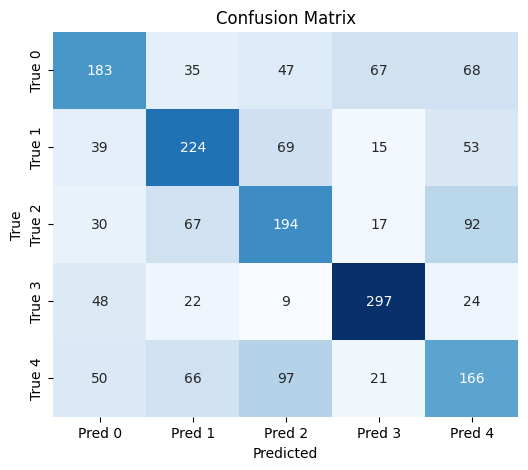

In [ ]:
train_cm = bayes_cm(train3, means, P, C)

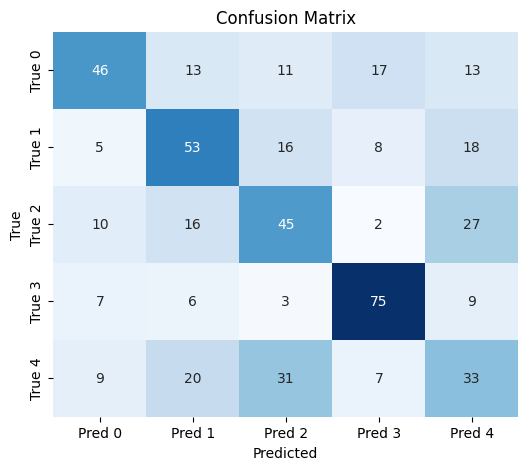

In [ ]:
test_cm = bayes_cm(test3, means, P, C)

In [ ]:
bayes_metrics(test_cm)

Test Dataset

Class 0
	Precision: 0.597
	Recall: 0.460
	F1 Score: 0.520

Class 1
	Precision: 0.491
	Recall: 0.530
	F1 Score: 0.510

Class 2
	Precision: 0.425
	Recall: 0.450
	F1 Score: 0.437

Class 3
	Precision: 0.688
	Recall: 0.750
	F1 Score: 0.718

Class 4
	Precision: 0.330
	Recall: 0.330
	F1 Score: 0.330

Average Precision: 0.506
Average Recall: 0.504
Average F1 Score: 0.503



### b. Covariances Matrices are different

In [ ]:
C = np.zeros((36, 36, 5))
for lab in range(5):
  C[:, :, lab] = np.cov(train3[train3["label"] == lab].iloc[:, :-1].T)

In [ ]:
def bayes(X, means, P, C):
  probs = []
  for lab in range(5):
    diff = np.array(X) - means[lab]
    prob = -0.5 * diff.T @ np.linalg.inv(C[:, :, lab]) @ diff + np.log(P[lab])
    probs.append(prob)

  return np.argmax(probs)

In [ ]:
train_acc = bayes_acc(train3, means, P, C)
val_acc = bayes_acc(val3, means, P, C)
test_acc = bayes_acc(test3, means, P, C)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

Training accuracy: 62.450
Validation accuracy: 41.800
Test accuracy: 41.000


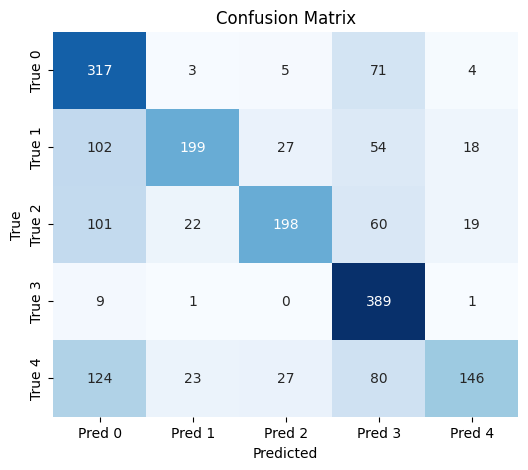

In [ ]:
train_cm = bayes_cm(train3, means, P, C)

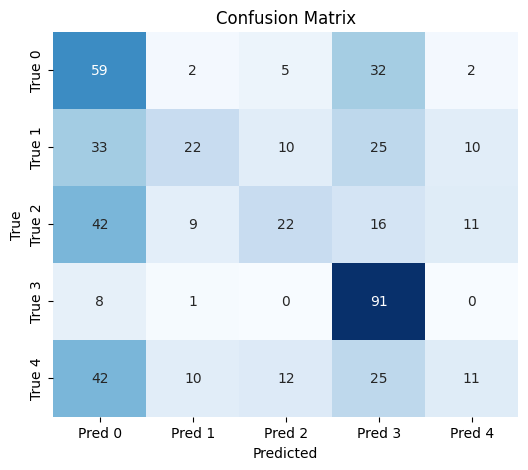

In [ ]:
test_cm = bayes_cm(test3, means, P, C)

In [ ]:
bayes_metrics(test_cm)

Test Dataset

Class 0
	Precision: 0.321
	Recall: 0.590
	F1 Score: 0.415

Class 1
	Precision: 0.500
	Recall: 0.220
	F1 Score: 0.306

Class 2
	Precision: 0.449
	Recall: 0.220
	F1 Score: 0.295

Class 3
	Precision: 0.481
	Recall: 0.910
	F1 Score: 0.630

Class 4
	Precision: 0.324
	Recall: 0.110
	F1 Score: 0.164

Average Precision: 0.415
Average Recall: 0.410
Average F1 Score: 0.362

